In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle


from adefc_vortex.math_module import xp, xcipy, ensure_np_array
from adefc_vortex import utils
from adefc_vortex.imshows import imshow1, imshow2, imshow3, plot_data
import adefc_vortex.scoob_interface as scoobi

import lina

print(scoobi.__file__)
print(lina.__file__)

import purepyindi
from purepyindi import INDIClient
import purepyindi2
from purepyindi2 import IndiClient

client0 = INDIClient('localhost', 7624)
client0.start()

client = IndiClient()
client.connect()
client.get_properties()

def restart_clients():
    client0 = INDIClient('localhost', 7624)
    client0.start()

    client = IndiClient()
    client.connect()
    client.get_properties()

/opt/conda/envs/km310env/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


/home/kianmilani/Projects/adefc-vortex/adefc_vortex/scoob_interface.py
/home/kianmilani/Projects/lina/lina/__init__.py


In [2]:
scoobi.home_block(client0)

In [3]:
scoobi.move_block_out(client0)

In [28]:
reload(scoobi)
xc, yc = (4600, 3400)
npsf = 256
scoobi.set_zwo_roi(xc, yc, npsf, client0)


In [4]:
reload(scoobi)
I = scoobi.SCOOBI(scicam_channel='camsci', dm_channel='dm00disp05')

# Do the normalization

In [17]:
scoobi.move_psf(50, 0, client0)

In [21]:
scoobi.move_psf(0, -50, client0)

In [29]:
reload(scoobi)
I.set_zwo_exp_time(0.000120, client0)

Set the ZWO exposure time to 1.20e-04s


In [30]:
reload(scoobi)
I.set_zwo_gain(120, client0)

Set the ZWO gain setting to 120.0


In [31]:
reload(scoobi)
I.set_fib_atten(32, client)

Set the fiber attenuation to 32.0


43225.1


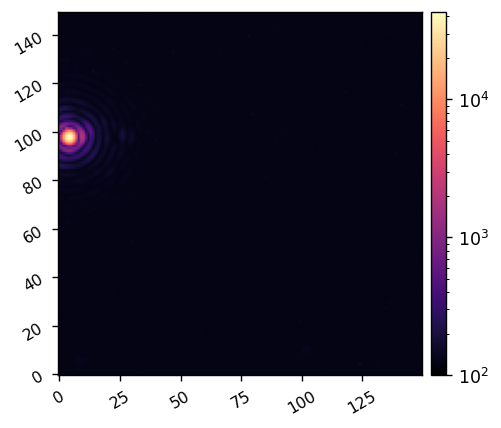

In [32]:
I.NSCICAM = 200
ref_psf = I.snap()
print(xp.max(ref_psf))
imshow1(ref_psf, lognorm=True, vmin=1e2)


In [33]:
I.ref_psf_params = {
    'ref_psf':copy.copy(ref_psf),
    'Imax': copy.copy(xp.max(ref_psf)),
    'texp': copy.copy(I.texp), 
    'atten': copy.copy(I.atten),
    'gain': copy.copy(I.gain),
}
utils.save_pickle(f'data/{today}_ref_psf_params.pkl', I.ref_psf_params)
print(I.ref_psf_params)

Saved data to:  data/20250117_ref_psf_params.pkl
{'ref_psf': array([[127.46, 130.34, 128.08, ..., 129.86, 127.08, 128.94],
       [127.7 , 126.2 , 128.2 , ..., 128.18, 129.02, 126.86],
       [128.3 , 128.64, 128.56, ..., 128.48, 129.6 , 126.48],
       ...,
       [128.  , 128.38, 128.9 , ..., 127.02, 127.98, 128.94],
       [127.44, 127.32, 127.5 , ..., 126.96, 127.68, 127.24],
       [126.62, 129.5 , 128.16, ..., 128.02, 128.42, 128.6 ]]), 'Imax': array(43225.1), 'texp': 0.00012, 'atten': 32, 'gain': 120}


In [22]:
I.ref_psf_params = utils.load_pickle(f'data/{today}_ref_psf_params.pkl')
print(I.ref_psf_params)

{'ref_psf': array([[128.56, 130.26, 128.46, ..., 130.47, 127.87, 129.59],
       [126.08, 126.51, 128.82, ..., 128.13, 129.39, 128.08],
       [128.53, 127.66, 127.67, ..., 128.71, 128.88, 125.93],
       ...,
       [128.49, 128.09, 129.68, ..., 128.08, 127.41, 128.42],
       [127.56, 125.89, 127.78, ..., 126.78, 127.93, 128.78],
       [129.94, 128.62, 128.91, ..., 129.12, 128.12, 128.65]]), 'Imax': array(22916.29), 'texp': 0.00025, 'atten': 37, 'gain': 120}


# Move back onto the vortex and adjust exposure times

In [68]:
scoobi.move_psf(-1, 0, client0)

In [70]:
scoobi.move_psf(0, -1, client0)

In [155]:
I.reset_dm()

In [71]:
I.set_fib_atten(0, client)

Set the fiber attenuation to 0.0


In [73]:
I.set_zwo_exp_time(0.0005, client0)

Set the ZWO exposure time to 5.00e-04s


In [74]:
I.set_zwo_gain(120, client0)

Set the ZWO gain setting to 120.0


# Make a function to adjust bias on the camera
camsci.blacklevel.target

In [26]:
reload(scoobi)
scoobi.move_block_in(client0)

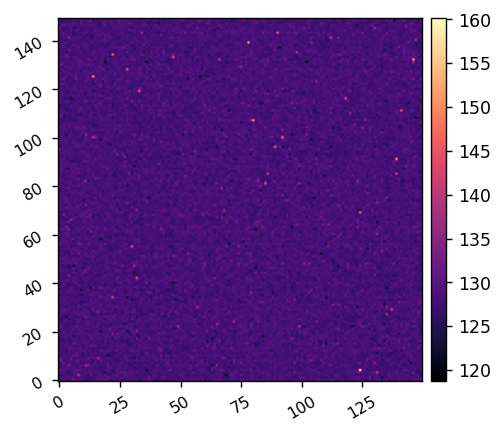

In [77]:
# I.NSCICAM = 200
# I.subtract_dark = False
# I.return_ni = False
# dark_frame = I.snap()
# utils.save_pickle(f'data/{today}_camsci_dark_frame_{I.texp:.6f}.pkl', dark_frame)
# I.df = copy.copy(dark_frame)

dark_frame = utils.load_pickle(f'data/20250116_camsci_dark_frame_0.000500.pkl')
I.df = copy.copy(dark_frame)

imshow1(dark_frame)

In [29]:
reload(scoobi)
scoobi.move_block_out(client0)

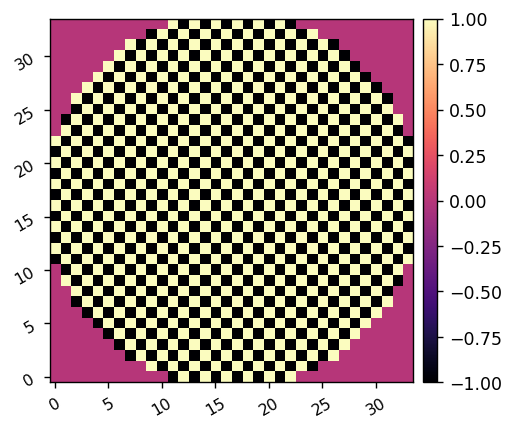

In [78]:
reload(scoobi.utils)
waffle_command = utils.make_fourier_command(x_cpa=17, y_cpa=17) * xp.array(I.dm_mask)
imshow1(waffle_command)

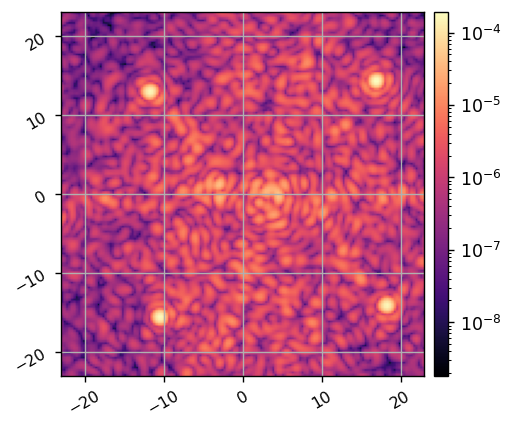

In [79]:
I.set_dm(10e-9 * waffle_command)
I.x_shift = 0
I.y_shift = 0

I.NSCICAM = 100
I.subtract_dark = True
I.return_ni = True
waffle_im = I.snap()
imshow1(waffle_im, lognorm=True, pxscl=I.psf_pixelscale_lamDc, grid=True)

Centroids:
 [[ 40.38123923  23.84022268]
 [ 36.17218032 116.63330465]
 [129.4798619  121.07098773]
 [133.90801935  28.5452458 ]
 [ 40.38123923  23.84022268]]


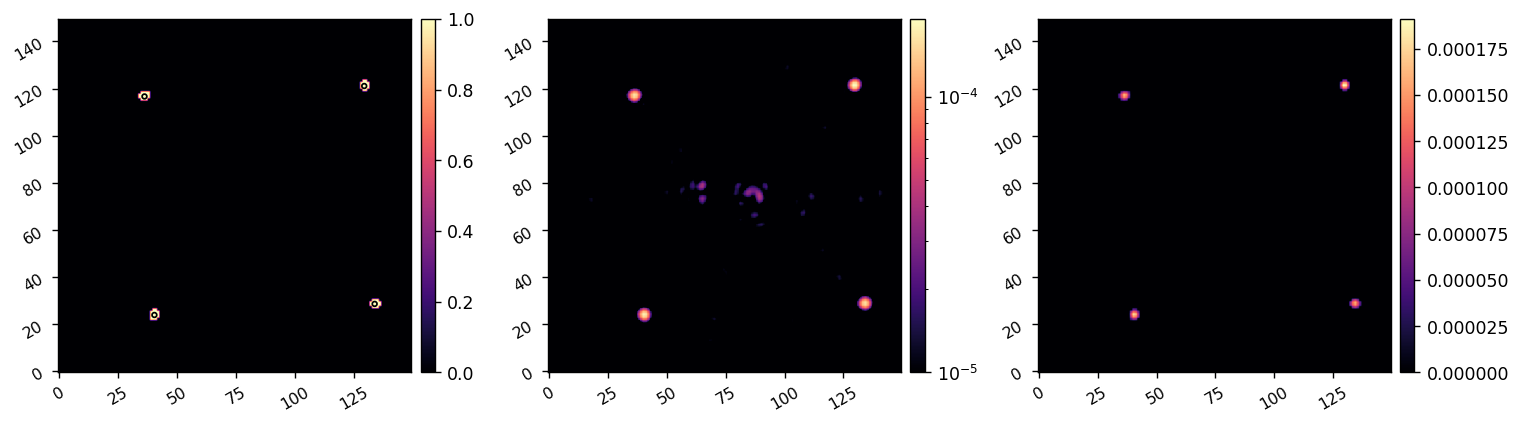

Angle:  87.26500172542546
Measured center in X:  85.04718723030334
Measured center in Y:  72.58288744493282
Required shift in X:  -10.0
Required shift in Y:  2.0


In [80]:
reload(scoobi.utils)

xshift,yshift,angle = scoobi.utils.measure_center_and_angle(waffle_im, I.psf_pixelscale_lamDc, im_thresh=5e-5, r_thresh=16)

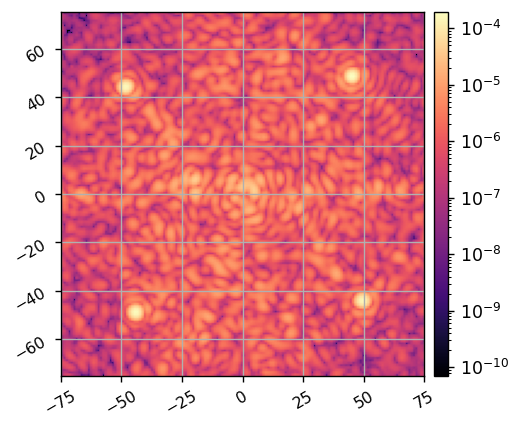

In [82]:
I.NSCICAM = 10
I.npsf = 150
I.x_shift = xshift
I.y_shift = yshift

I.subtract_dark = True
I.return_ni = True

coro_im = I.snap()
imshow1(coro_im, lognorm=True, pxscl=1, grid=True)

In [53]:
I.zero_dm()

# Choose modes and probes for iEFC

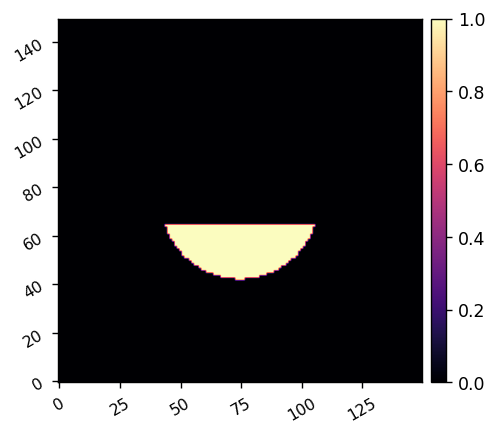

In [83]:
reload(lina.utils)

iwa = 3
owa = 10
rotation = 90
control_mask = lina.utils.create_annular_focal_plane_mask(
    I.npsf, 
    I.psf_pixelscale_lamDc, 
    iwa, 
    owa, 
    edge=iwa, 
    rotation=rotation,
    plot=1,
)

2.0258664210831875e-06


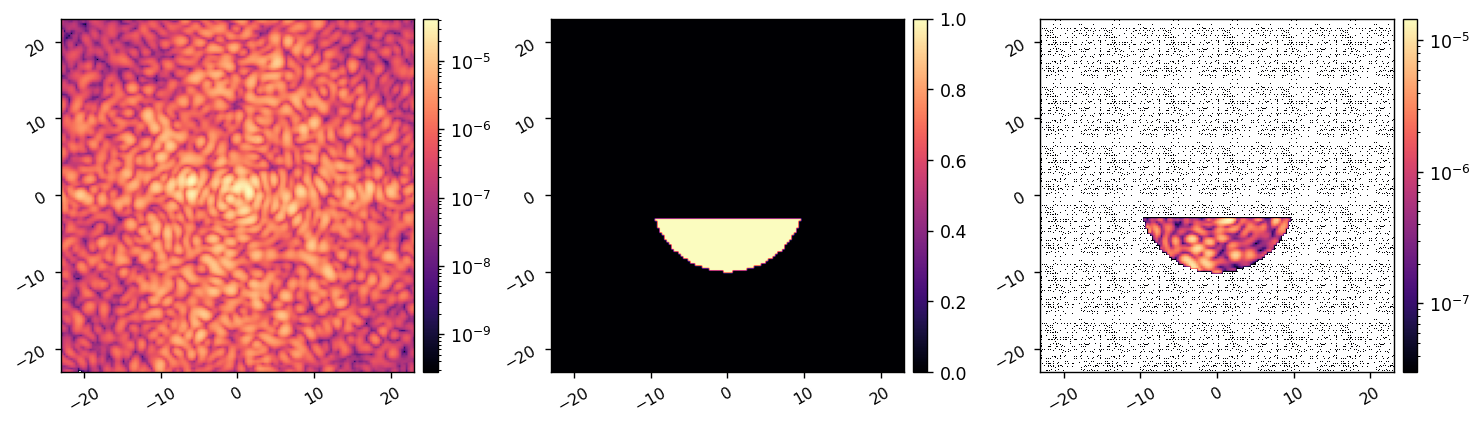

In [84]:
I.zero_dm()
I.NSCICAM = 50
I.subtract_dark = True
I.return_ni = True
# I.set_zwo_exp_time(0.0005, client0)

ref_coro_im = I.snap()
print(xp.mean(ref_coro_im[control_mask]))
imshow3(ref_coro_im, control_mask, control_mask * ref_coro_im,
        lognorm1=True, lognorm3=True, pxscl=I.psf_pixelscale_lamDc)

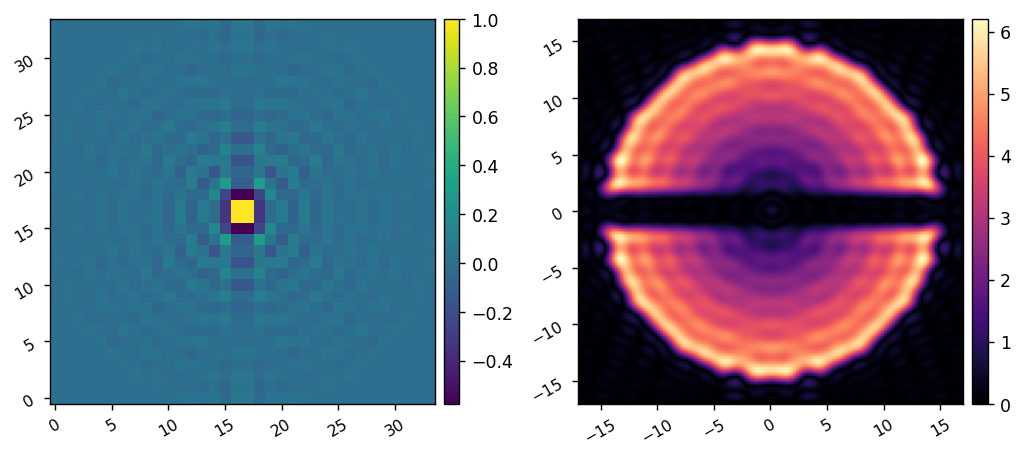

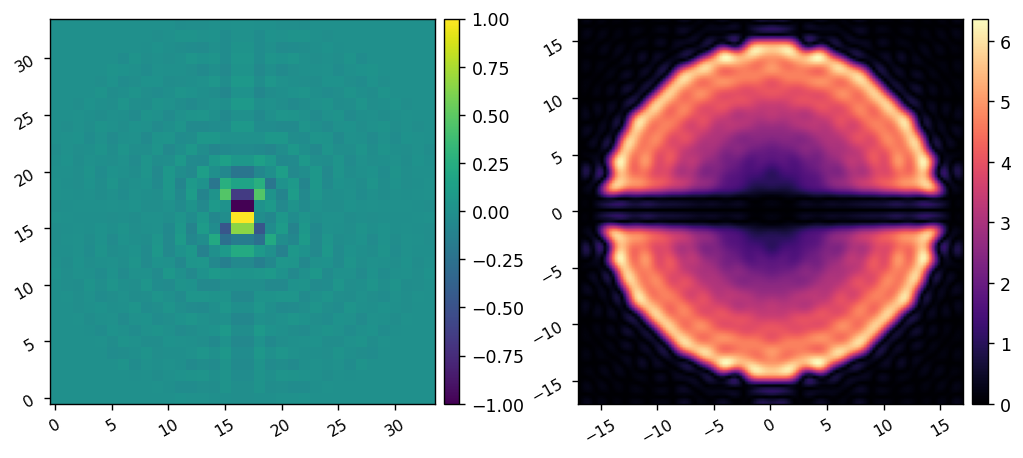

In [85]:
reload(lina.utils)
probe_iwa = 2
probe_owa = 14

probe_modes = lina.utils.create_fourier_probes(
    xp.array(I.dm_mask), 
    I.npsf, 
    I.psf_pixelscale_lamDc, 
    probe_iwa, 
    probe_owa, 
    rotation=rotation,
    fourier_sampling=0.75, 
    shifts=None, 
    nprobes=2,
    use_weighting=True, 
    plot=True,
)

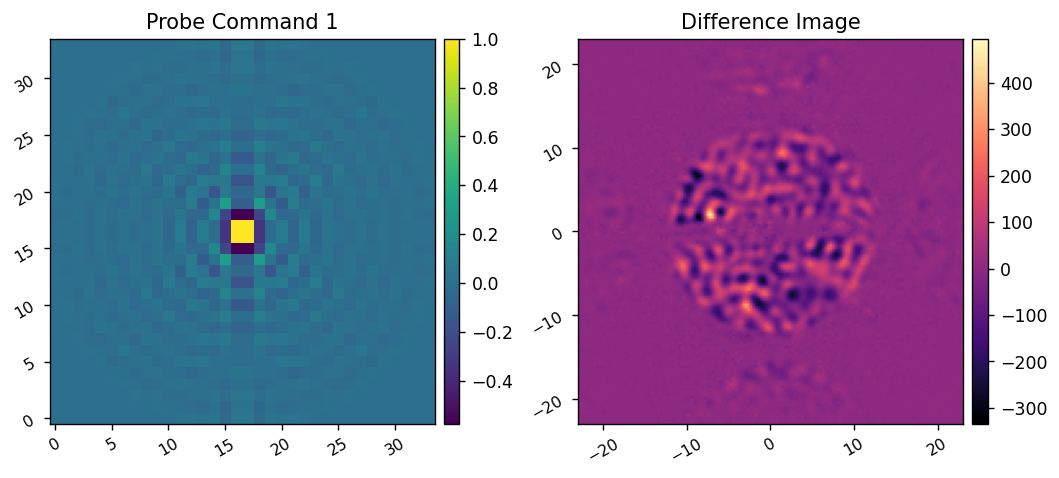

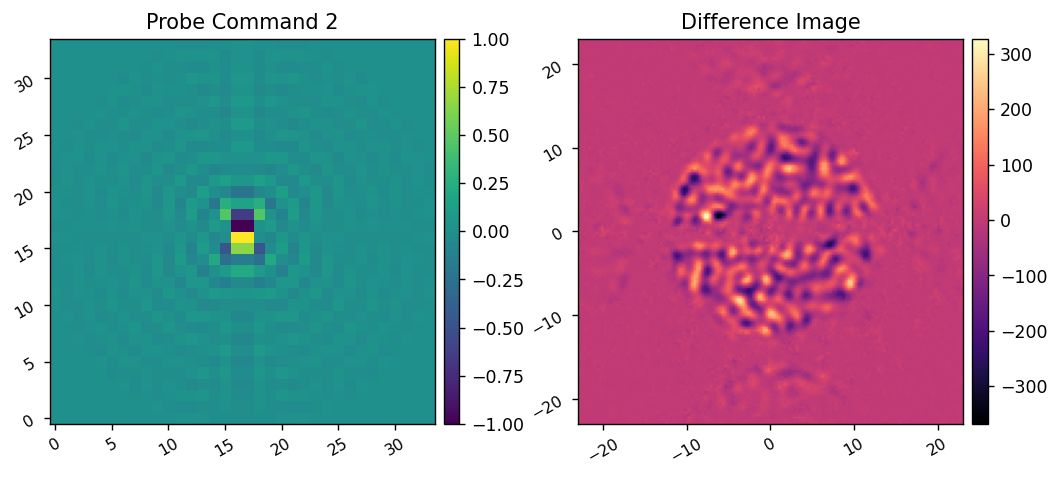

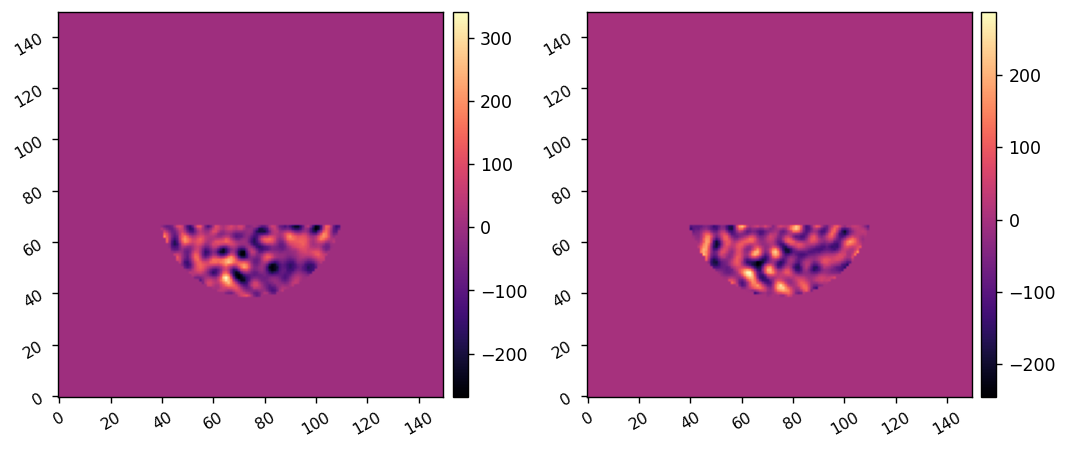

In [42]:
reload(lina.iefc)

time.sleep(3)
I.NSCICAM = 40
I.subtract_dark = False
I.return_ni = True

diff_ims = lina.iefc.take_measurement(
    I, 
    probe_modes, 
    3e-9, 
    plot=True,
)
diff_ims *= control_mask
imshow2(diff_ims[0], diff_ims[1])
# imshow3(diff_ims[0], diff_ims[1], diff_ims[2])

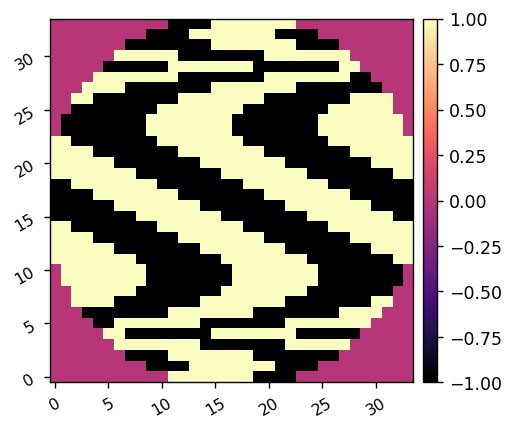

In [86]:
reload(lina.utils)
calib_modes = lina.utils.create_hadamard_modes(xp.array(I.dm_mask))
imshow1(calib_modes[8])


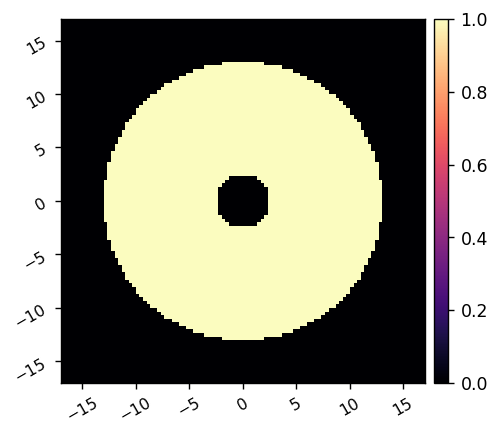

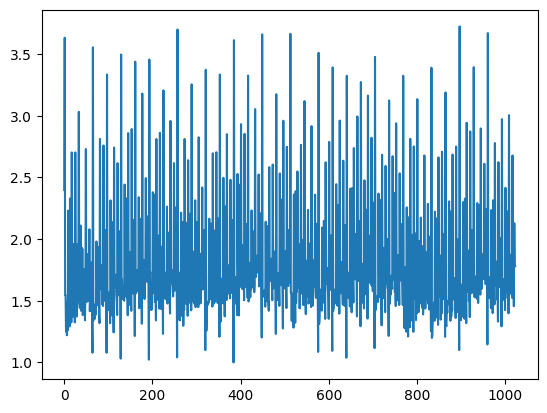

[1.26141126 2.2314004  1.69366311 1.7770875 ]


In [93]:
reload(lina.iefc)
scale_factors = lina.iefc.compute_hadamard_scale_factors(calib_modes, scale_exp=1/5, scale_thresh=4, oversamp=3, plot=True)
print(scale_factors[8:12])

In [89]:
I.zero_dm()

In [94]:
reload(lina.iefc)
I.zero_dm()

probe_amp = 3e-9
calib_amp = 2e-9

I.NSCICAM = 20
I.return_ni = True
I.subtract_dark = False
I.dm_delay = I.texp * 2
print(I.dm_delay)

# time.sleep(2)
response_matrix, response_cube = lina.iefc.calibrate(
    I, 
    control_mask, 
    probe_amp, 
    probe_modes, 
    calib_amp, 
    calib_modes, 
    scale_factors=scale_factors, 
#  calib_amp, calib_modes[100:110], 
#  scale_factors=scale_factors[100:110], 
#  calib_amp, calib_modes[8:12], 
#  scale_factors=scale_factors[8:12], 
    return_all=True,
)

0.001
Calibrating iEFC...
	Calibrated mode 1024/1024 in 1145.440s
Calibration complete.


In [95]:
iefc_calib_data = {
    'response_matrix':response_matrix,
    'response_cube':response_cube,
    'control_mask':control_mask,
    'NSCICAM':I.NSCICAM,
    'probe_amp':probe_amp,
    'probe_modes':probe_modes,
    'calib_amp':calib_amp,
    'scale_factors':scale_factors,
}
lina.utils.save_pickle(f'data/{today}_iefc_calib.pkl', iefc_calib_data)

Saved data to:  data/20250117_iefc_calib.pkl


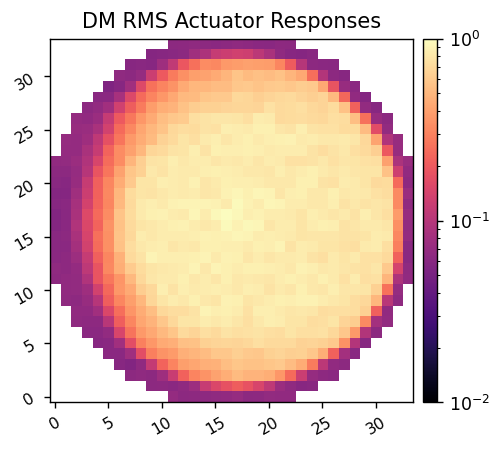

In [96]:
calib_data = utils.load_pickle(f'data/{today}_iefc_calib.pkl')
response_cube = calib_data['response_cube']
response_matrix = response_cube[:, :, control_mask.ravel()].reshape(1024, -1).T

dm_response_map = xp.sqrt(xp.mean(xp.square(response_matrix.dot(calib_modes.reshape(1024, -1))), axis=0))
dm_response_map = dm_response_map.reshape(I.Nact,I.Nact) / xp.max(dm_response_map)
imshow1(dm_response_map, 'DM RMS Actuator Responses', lognorm=True, vmin=1e-2)

In [97]:
cm1 = lina.utils.beta_reg(response_matrix, -2.5)
cm2 = lina.utils.beta_reg(response_matrix, -5)


In [98]:
I.zero_dm()
data = {
    'images':[ref_coro_im],
    'commands':[],
    'del_commands':[],
    'pixelscale':I.psf_pixelscale_lamDc,
    'control_mask':control_mask, 
    'probes':probe_modes,
}

0.2
Running iEFC...
	Closed-loop iteration 27 / 30


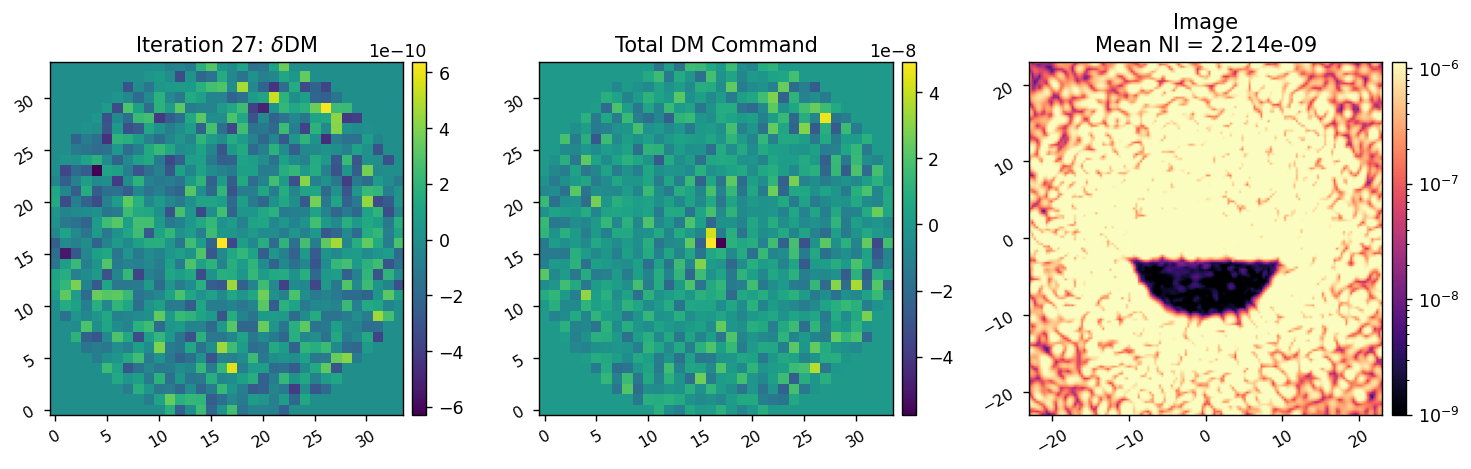

	Closed-loop iteration 28 / 30


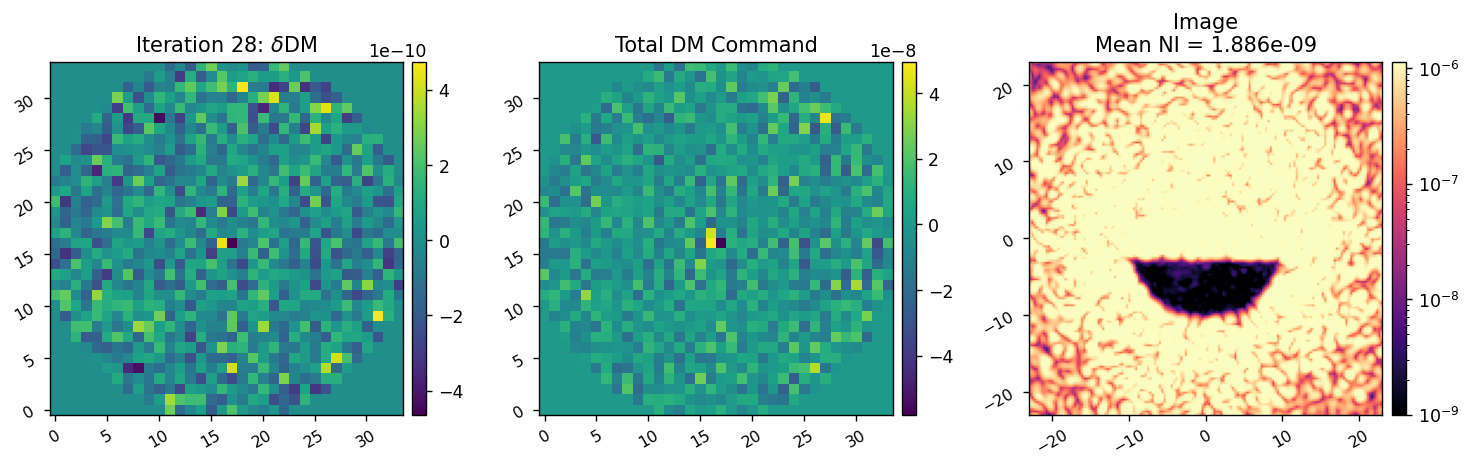

	Closed-loop iteration 29 / 30


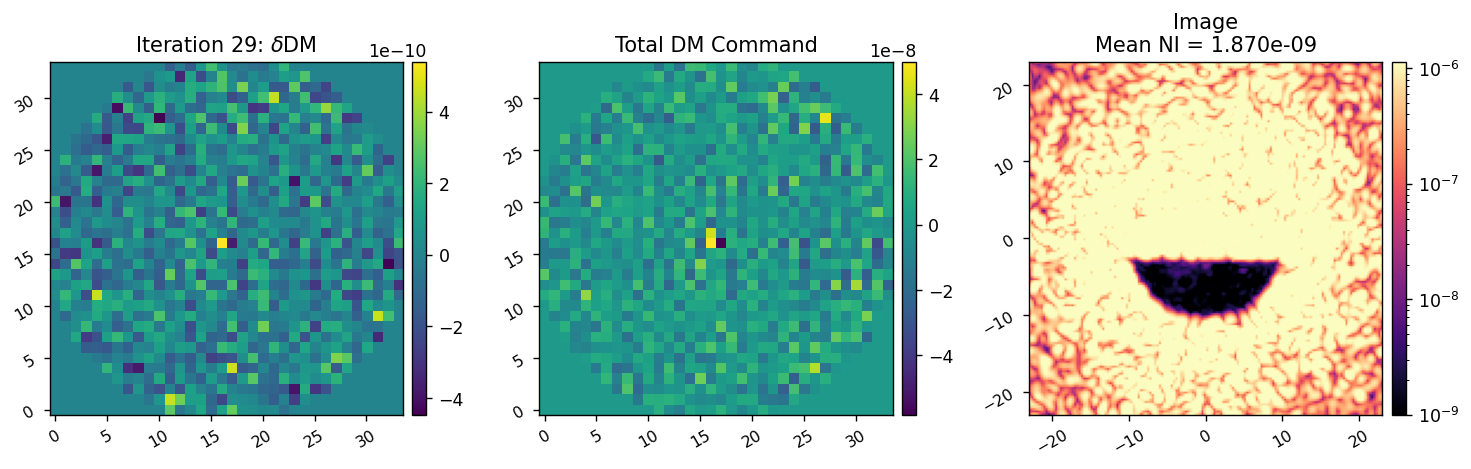

	Closed-loop iteration 30 / 30


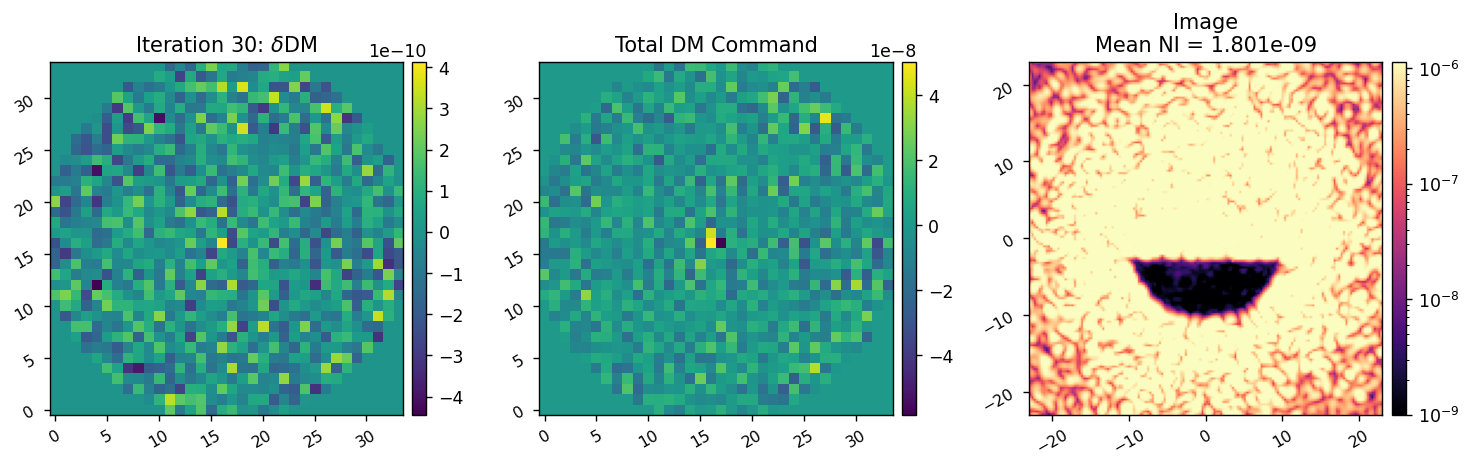

Closed loop for given control matrix completed in 209.802s.


In [114]:
reload(lina.utils)
reload(lina.iefc)

probe_amp = 5e-9
probe_amp = 4e-9
probe_amp = 3e-9
probe_amp = 2.5e-9
# probe_amp = 2e-9
# probe_amp = 1.5e-9
# probe_amp = 1e-9
# probe_amp = 0.75e-9
# probe_amp = 0.5e-9
probe_amp = 0.25e-9

I.NSCICAM = 100
I.return_ni = True
I.dm_delay = 2*I.texp
print(I.dm_delay)

data = lina.iefc.run(
    I,
    data,
    cm1,
    # cm2,
    probe_modes, 
    probe_amp, 
    calib_modes,
    control_mask,
    num_iterations=4,
    loop_gain=0.75, 
    leakage=0.0,
    plot_current=True,
    plot_all=True,
    plot_probes=False,
    plot_radial_contrast=False,
)

In [116]:
utils.save_pickle(f'data/{today}_iefc_run.pkl', data)


Saved data to:  data/20250117_iefc_run.pkl


In [72]:
print(I.texp, I.gain, I.atten)
print(I.ref_psf_params)

0.1 120 0
{'ref_psf': array([[128.56, 130.26, 128.46, ..., 130.47, 127.87, 129.59],
       [126.08, 126.51, 128.82, ..., 128.13, 129.39, 128.08],
       [128.53, 127.66, 127.67, ..., 128.71, 128.88, 125.93],
       ...,
       [128.49, 128.09, 129.68, ..., 128.08, 127.41, 128.42],
       [127.56, 125.89, 127.78, ..., 126.78, 127.93, 128.78],
       [129.94, 128.62, 128.91, ..., 129.12, 128.12, 128.65]]), 'Imax': array(22916.29), 'texp': 0.00025, 'atten': 37, 'gain': 120}


In [100]:
# I.set_fib_atten(5, client)
I.set_zwo_exp_time(0.1, client0, delay=1)
I.set_zwo_gain(120, client0)

Set the ZWO exposure time to 1.00e-01s
Set the ZWO gain setting to 120.0


In [55]:
reload(scoobi)
scoobi.move_block_in(client0)

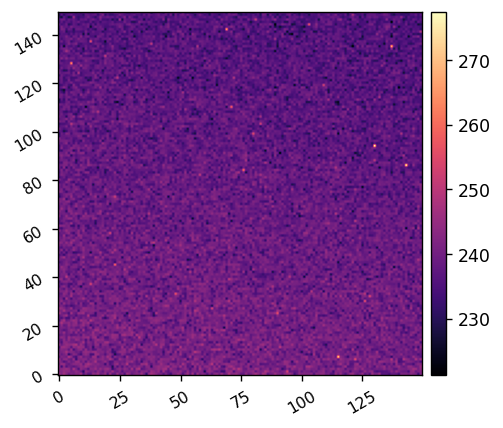

In [102]:
# I.NSCICAM = 200
# I.subtract_dark = False
# I.return_ni = False
# dark_frame = I.snap()
# utils.save_pickle(f'data/{today}_camsci_dark_frame_{I.texp:.6f}.pkl', dark_frame)
# imshow1(dark_frame)

dark_frame = utils.load_pickle(f'data/20250116_camsci_dark_frame_0.100000.pkl')
imshow1(dark_frame)

I.df = copy.copy(dark_frame)

In [57]:
reload(scoobi)
scoobi.move_block_out(client0)

1.846113650381386e-09


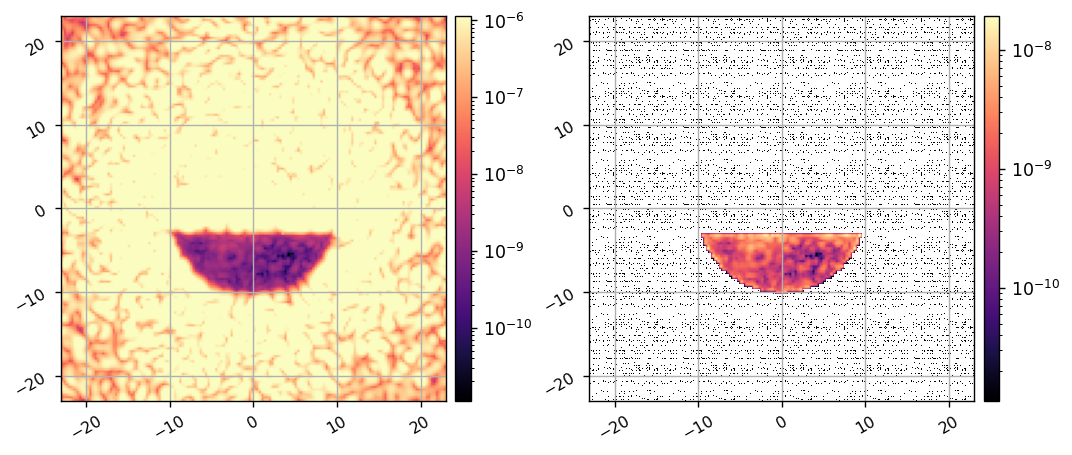

In [117]:
I.NSCICAM = 100
I.subtract_dark = True
I.return_ni = True

coro_im = I.snap()

print(xp.mean(coro_im[control_mask]))
imshow2(coro_im, control_mask * coro_im, grid=True, lognorm=True, pxscl=I.psf_pixelscale_lamDc)

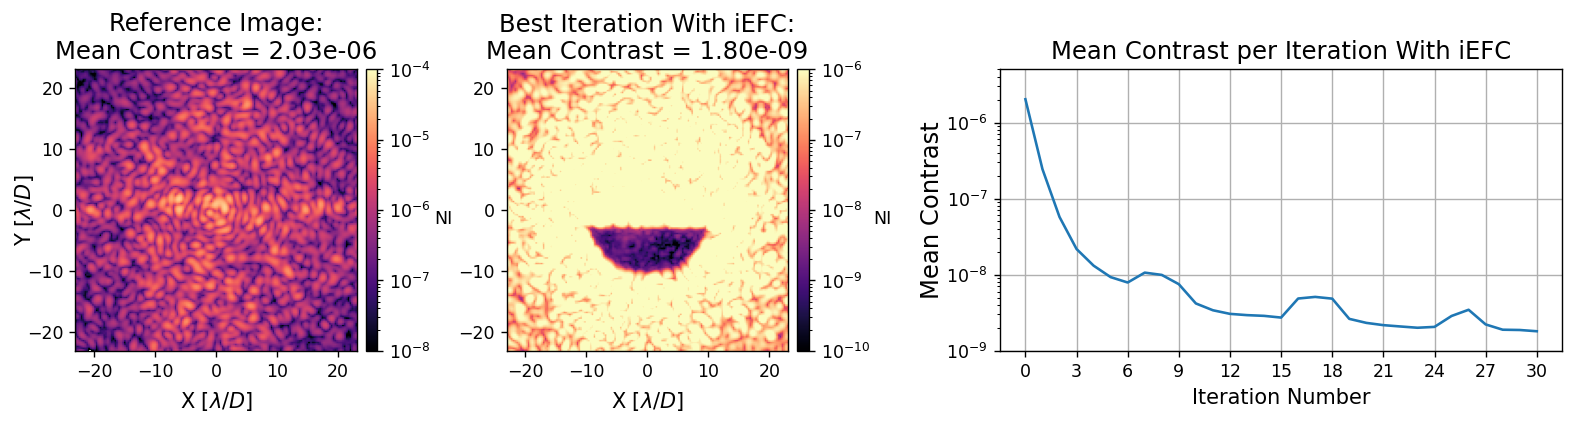

In [119]:
from adefc_vortex import imshows
reload(imshows)

# old_data = utils.load_pickle('data/20250116_iefc_run.pkl')
old_data = utils.load_pickle('data/20250117_iefc_run.pkl')

imshows.plot_data_with_ref(
    data, 
    im1vmax=1e-4, im1vmin=1e-8, 
    im2vmax=1e-6, im2vmin=1e-10, 
    vmax=5e-6, vmin=1e-9, 
    xticks=np.arange(0, 30+1, 3),
    exp_name=' With iEFC',
    fname='../figs/scoob_mono_iefc.pdf',
)

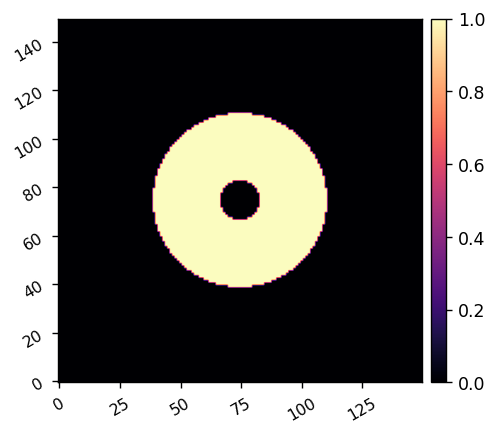

In [79]:
iwa = 2.5
owa = 11
rotation = 90
control_mask = lina.utils.create_annular_focal_plane_mask(
    I.npsf, 
    I.psf_pixelscale_lamDc, 
    iwa, 
    owa, 
    # edge=iwa, 
    rotation=rotation,
    plot=1,
)

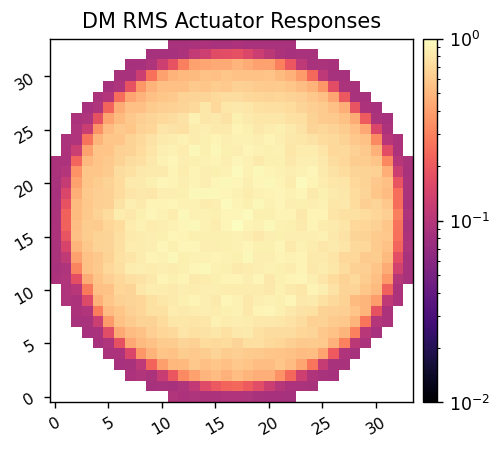

In [80]:
calib_data = utils.load_pickle(f'data/{today}_iefc_calib.pkl')
response_cube = calib_data['response_cube']
response_matrix = response_cube[:, :, control_mask.ravel()].reshape(1024, -1).T

dm_response_map = xp.sqrt(xp.mean(xp.square(response_matrix.dot(calib_modes.reshape(1024, -1))), axis=0))
dm_response_map = dm_response_map.reshape(I.Nact,I.Nact) / xp.max(dm_response_map)
imshow1(dm_response_map, 'DM RMS Actuator Responses', lognorm=True, vmin=1e-2)